# STATS 503 Data Challenge
## ChengYu Ko

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the path
file_path = 'D:\\Studies\\UMich\\MAE Program\\2023 Winter\\STATS 503\\Data Challenge\\x_all'
# list all the files from the directory
file_list = glob.glob(os.path.join(file_path, '*.txt'))

In [3]:
# import train and test data
train_outcome = pd.read_csv('train_outcome.csv')
test_nolabel = pd.read_csv('test_nolabel.csv')

# split the train_outcome to train & val
from sklearn.model_selection import train_test_split
y_train_wID, y_val_wID = train_test_split(train_outcome, test_size=0.2, random_state=100, stratify=train_outcome['Outcome'], shuffle=True)

# extract train, val, test ID data
train_ID = y_train_wID['ID'].to_list()
val_ID = y_val_wID['ID'].to_list()
test_ID = test_nolabel['ID'].to_list()

In [4]:
# find the train, val, and test data
train_list = []
val_list = []
test_list = []

for j in file_list:
    for i in train_ID:
        if i == int(j.split('\\')[-1].split('.')[0]):
            train_list.append(j)

for j in file_list:
    for i in val_ID:
        if i == int(j.split('\\')[-1].split('.')[0]):
            val_list.append(j)

for j in file_list:
    for i in test_ID:
        if i == int(j.split('\\')[-1].split('.')[0]):
            test_list.append(j)

In [5]:
# original data transformation
# X_train
df_list = []
for t in train_list:
    df = pd.read_csv(t)
    df = df.pivot(index='Hour', columns=['Variable'], values='Value')
    df = df.reset_index()
    df.columns.name = None
    # fill in the fixed values (demographics)
    df['ID'] = df['ID'].fillna(df['ID'].max())
    df['Age'] = df['Age'].fillna(df['Age'].max())
    df['Gender'] = df['Gender'].fillna(df['Gender'].max())
    df_list.append(df)
# concatenate dataframes
X_train = pd.concat(df_list, axis=0)
X_train = X_train.sort_values(by=['ID', 'Hour'])

# X_val
df_list = []
for v in val_list:
    df = pd.read_csv(v)
    df = df.pivot(index='Hour', columns=['Variable'], values='Value')
    df = df.reset_index()
    df.columns.name = None
    # fill in the fixed values (demographics)
    df['ID'] = df['ID'].fillna(df['ID'].max())
    df['Age'] = df['Age'].fillna(df['Age'].max())
    df['Gender'] = df['Gender'].fillna(df['Gender'].max())
    df_list.append(df)
# concatenate dataframes
X_val = pd.concat(df_list, axis=0)
X_val = X_val.sort_values(by=['ID', 'Hour'])

# X_test
df_list = []
for t in test_list:
    df = pd.read_csv(t)
    df = df.pivot(index='Hour', columns=['Variable'], values='Value')
    df = df.reset_index()
    df.columns.name = None
    # fill in the fixed values (demographics)
    df['ID'] = df['ID'].fillna(df['ID'].max())
    df['Age'] = df['Age'].fillna(df['Age'].max())
    df['Gender'] = df['Gender'].fillna(df['Gender'].max())
    df_list.append(df)
# concatenate dataframes
X_test = pd.concat(df_list, axis=0)
X_test = X_test.sort_values(by=['ID', 'Hour'])

In [6]:
# y_train
y_train = train_outcome.loc[train_outcome['ID'].isin(X_train.ID.unique())]
y_train = y_train.set_index('ID')

# y_val
y_val = train_outcome.loc[train_outcome['ID'].isin(X_val.ID.unique())]
y_val = y_val.set_index('ID')

In [7]:
# mean imputation by grouping ID
imputed_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
                   'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST','BUN', 'Alkalinephos', 'Calcium', 'Chloride',
                   'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium','Phosphate',
                   'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen',
                   'Platelets', 'Unit1', 'Unit2']

# X_train
X_train_imp = X_train
for i in imputed_columns:
    X_train_imp[i] = X_train.groupby('ID')[i].transform(lambda x: x.fillna(x.mean()))

# X_val
X_val_imp = X_val
for i in imputed_columns:
    X_val_imp[i] = X_val.groupby('ID')[i].transform(lambda x: x.fillna(x.mean()))

# X_test
X_test_imp = X_test
for i in imputed_columns:
    X_test_imp[i] = X_test.groupby('ID')[i].transform(lambda x: x.fillna(x.mean()))

In [8]:
# calculate summary statistics by 1 expanding windows to capture the time effect
# X_train
expanding_train = []
for id in X_train_imp['ID'].unique():
    df = X_train_imp.loc[X_train_imp['ID'] == id]
    df1 = pd.DataFrame(df.expanding(1).mean().iloc[-1, :]).T
    expanding_train.append(df1)
# concatenate dataframes
X_train_expanding = pd.concat(expanding_train, axis=0)
X_train_expanding = X_train_expanding.sort_values(by=['ID'])
X_train_expanding = X_train_expanding.reset_index(drop=True)

# X_val
expanding_val = []
for id in X_val_imp['ID'].unique():
    df = X_val_imp.loc[X_val_imp['ID'] == id]
    df1 = pd.DataFrame(df.expanding(1).mean().iloc[-1, :]).T
    expanding_val.append(df1)
# concatenate dataframes
X_val_expanding = pd.concat(expanding_val, axis=0, ignore_index=True)
X_val_expanding = X_val_expanding.sort_values(by=['ID'])
X_val_expanding = X_val_expanding.reset_index(drop=True)

# X_test
expanding_test = []
for id in X_test_imp['ID'].unique():
    df = X_test_imp.loc[X_test_imp['ID'] == id]
    df1 = pd.DataFrame(df.expanding(1).mean().iloc[-1, :]).T
    expanding_test.append(df1)
# concatenate dataframes
X_test_expanding = pd.concat(expanding_test, axis=0)
X_test_expanding = X_test_expanding.sort_values(by=['ID'])
X_test_expanding = X_test_expanding.reset_index(drop=True)

In [9]:
# drop Unit1 and Unit2
X_train_expanding1 = X_train_expanding.set_index('ID').drop(['Unit1', 'Unit2'], axis=1)
X_val_expanding1 = X_val_expanding.set_index('ID').drop(['Unit1', 'Unit2'], axis=1)
X_test_expanding1 = X_test_expanding.set_index('ID').drop(['Unit1', 'Unit2'], axis=1)

In [10]:
# MICE imputation for all of the remaining NaNs
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=20, random_state=100)

# X_train
X_train_mice = imp.fit_transform(X_train_expanding1)
X_train_mice = pd.DataFrame(X_train_mice, columns=X_train_expanding1.columns)

# X_val
X_val_mice = imp.fit_transform(X_val_expanding1)
X_val_mice = pd.DataFrame(X_val_mice, columns=X_val_expanding1.columns)

# X_test
X_test_mice = imp.fit_transform(X_test_expanding1)
X_test_mice = pd.DataFrame(X_test_mice, columns=X_test_expanding1.columns)

In [11]:
# deal with imbalanced data by synthetic minority oversampling technique
from imblearn.over_sampling import SMOTE

# fit predictor and target variable
smote = SMOTE(random_state=100)
X_train_smote, y_train_smote = smote.fit_resample(X_train_mice, y_train)

# Cross-Validation Setting

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Random Forest

In [13]:
hyper_params_rf = [{'n_estimators': [1, 2, 5, 10, 50, 80, 100],
                    'max_depth': [1, 2, 5, 10, 20, 50, 100],
                    'max_leaf_nodes': [1, 2, 5, 10, 30, 50, 100, 150],
                    'max_features': [1, 2, 5, 6, 10, 20, 30, 40, 50]}]

In [14]:
from sklearn.ensemble import RandomForestClassifier

# model selection by 5-fold cross-validation
model_rf = RandomForestClassifier(random_state=100)
model_rf_cv = GridSearchCV(estimator=model_rf,
                           param_grid=hyper_params_rf,
                           scoring='accuracy',
                           cv=folds,
                           n_jobs=-1)
model_rf_cv.fit(X_train_smote.iloc[:4000], y_train_smote[:4000])

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(random_state=100), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 5, 10, 20, 50, 100],
                          'max_features': [1, 2, 5, 6, 10, 20, 30, 40, 50],
                          'max_leaf_nodes': [1, 2, 5, 10, 30, 50, 100, 150],
                          'n_estimators': [1, 2, 5, 10, 50, 80, 100]}],
             scoring='accuracy')

In [15]:
model_rf_cv.best_params_

{'max_depth': 20,
 'max_features': 30,
 'max_leaf_nodes': 100,
 'n_estimators': 100}

In [16]:
# fit the best model
model_rf = RandomForestClassifier(n_estimators=model_rf_cv.best_params_['n_estimators'], max_depth=model_rf_cv.best_params_['max_depth'], max_leaf_nodes=model_rf_cv.best_params_['max_leaf_nodes'], max_features=model_rf_cv.best_params_['max_features'], random_state=100)
model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=20, max_features=30, max_leaf_nodes=100,
                       random_state=100)

In [17]:
# predict the val set
y_pred_rf = model_rf.predict(X_val_mice)
y_pred_prob_rf = model_rf.predict_proba(X_val_mice)

In [18]:
# calculate model accuracy
acc_rf = model_rf.score(X_val_mice, y_val)
acc_rf

0.9204357873885771

In [19]:
# calculate the area under the receiver operating characteristic curve
from sklearn.metrics import roc_curve, auc

# compute the true positive rate and the false positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_rf[:, 1])
auc_rf = auc(fpr, tpr)
auc_rf

0.8304011077296725

In [20]:
# calculate the balanced error rate
from sklearn.metrics import balanced_accuracy_score

ber_rf = 1 - balanced_accuracy_score(y_val, y_pred_rf)
ber_rf

0.19389341804207305

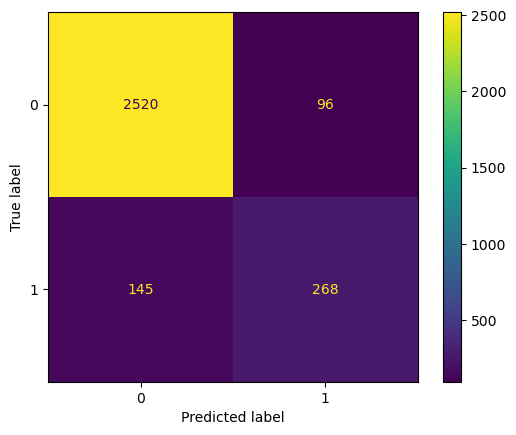

In [21]:
# confusion matrix for the val set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_val_rf = confusion_matrix(y_val, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf, display_labels=['0', '1'])
cm_display_rf.plot()
plt.show()

In [22]:
# predict the test set
y_pred_test_rf = model_rf.predict(X_test_mice)
y_pred_prob_test_rf = model_rf.predict_proba(X_test_mice)

In [23]:
test_results_rf = test_nolabel
test_results_rf['Outcome'] = y_pred_test_rf
test_results_rf['Score'] = y_pred_prob_test_rf[:, 1]

In [24]:
test_results_rf['Outcome'].value_counts()

0    4359
1    2131
Name: Outcome, dtype: int64

# AdaBoost with Decision Trees

In [25]:
hyper_params_ada = [{'n_estimators': [1, 5, 10, 20, 40, 50],
                     'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
                     'base_estimator__max_depth': [2, 5, 10, 20, 30, 50],
                     'base_estimator__max_features': [5, 10, 15, 30, 40, 50],
                     'base_estimator__max_leaf_nodes': [5, 10, 20, 40, 50]}]

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# model selection by 5-fold cross-validation
model_ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=100), random_state=100)
model_ada_cv = GridSearchCV(estimator=model_ada,
                            param_grid=hyper_params_ada,
                            scoring='accuracy',
                            cv=folds,
                            n_jobs=-1)
model_ada_cv.fit(X_train_smote.iloc[:5000], y_train_smote[:5000])

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100),
                                          random_state=100),
             n_jobs=-1,
             param_grid=[{'base_estimator__max_depth': [2, 5, 10, 20, 30, 50],
                          'base_estimator__max_features': [5, 10, 15, 30, 40,
                                                           50],
                          'base_estimator__max_leaf_nodes': [5, 10, 20, 40, 50],
                          'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
                          'n_estimators': [1, 5, 10, 20, 40, 50]}],
             scoring='accuracy')

In [27]:
model_ada_cv.best_params_

{'base_estimator__max_depth': 10,
 'base_estimator__max_features': 30,
 'base_estimator__max_leaf_nodes': 10,
 'learning_rate': 0.1,
 'n_estimators': 50}

In [28]:
# fit the best model
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=model_ada_cv.best_params_['base_estimator__max_depth'], max_features=model_ada_cv.best_params_['base_estimator__max_features'], max_leaf_nodes=model_ada_cv.best_params_['base_estimator__max_leaf_nodes'], random_state=100), n_estimators=model_ada_cv.best_params_['n_estimators'], learning_rate=model_ada_cv.best_params_['learning_rate'], random_state=100)
model_ada.fit(X_train_smote, y_train_smote)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         max_features=30,
                                                         max_leaf_nodes=10,
                                                         random_state=100),
                   learning_rate=0.1, random_state=100)

In [29]:
# predict the val set
y_pred_ada = model_ada.predict(X_val_mice)
y_pred_prob_ada = model_ada.predict_proba(X_val_mice)

In [30]:
# calculate the model accuracy
acc_ada = model_ada.score(X_val_mice, y_val)
acc_ada

0.9290194783757015

In [31]:
# calculate the area under the receiver operating characteristic curve
from sklearn.metrics import roc_curve, auc

# compute the true positive rate and the false positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_ada[:, 1])
auc_ada = auc(fpr, tpr)
auc_ada

0.8528042184063798

In [32]:
# calculate the balanced error rate
from sklearn.metrics import balanced_accuracy_score

ber_ada = 1 - balanced_accuracy_score(y_val, y_pred_ada)
ber_ada

0.23276345602772286

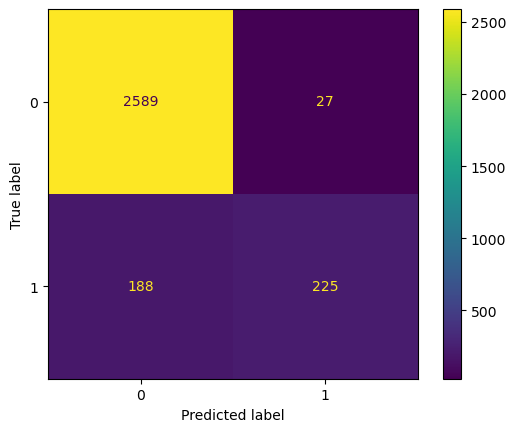

In [33]:
# confusion matrix for the val set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_val_ada = confusion_matrix(y_val, y_pred_ada)
cm_display_ada = ConfusionMatrixDisplay(confusion_matrix=cm_val_ada, display_labels=['0', '1'])
cm_display_ada.plot()
plt.show()

In [34]:
# predict the test set
y_pred_test_ada = model_ada.predict(X_test_mice)
y_pred_prob_test_ada = model_ada.predict_proba(X_test_mice)

In [35]:
test_results_ada = test_nolabel
test_results_ada['Outcome'] = y_pred_test_ada
test_results_ada['Score'] = y_pred_prob_test_ada[:, 1]

In [36]:
test_results_ada['Outcome'].value_counts()

0    5819
1     671
Name: Outcome, dtype: int64

In [37]:
# export the test results
test_results_ada.to_csv('test_results_ada.csv', index=False)

# Other Trials

# Logistic Regression

In [ ]:
hyper_params_log = [{'penalty': ['l1', 'l2', 'elasticnet'],
                     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                     'max_iter': [10, 20, 50, 100, 200]}]

In [ ]:
from sklearn.linear_model import LogisticRegression

# model selection by 5-fold cross-validation
model_log = LogisticRegression(random_state=100)
model_log_cv = GridSearchCV(estimator=model_log,
                            param_grid=hyper_params_log,
                            scoring='accuracy',
                            cv=folds,
                            n_jobs=-1)
model_log_cv.fit(X_train_smote, y_train_smote)

In [ ]:
model_log_cv.best_params_

In [ ]:
# fit the best model
model_log = LogisticRegression(penalty=model_log_cv.best_params_['penalty'], solver=model_log_cv.best_params_['solver'], max_iter=model_log_cv.best_params_['max_iter'], random_state=100)
model_log.fit(X_train_smote, y_train_smote)

In [ ]:
# predict the val set
y_pred_log = model_log.predict(X_val_mice)
y_pred_prob_log = model_log.predict_proba(X_val_mice)

In [ ]:
# calculate model accuracy
acc_log = model_log.score(X_val_mice, y_val)
acc_log

In [ ]:
# calculate the area under the receiver operating characteristic curve
from sklearn.metrics import roc_curve, auc 

# compute the true positive rate and the false positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_log[:, 1])
auc_log = auc(fpr, tpr)
auc_log

In [ ]:
# calculate the balanced error rate
from sklearn.metrics import balanced_accuracy_score

ber_log = 1 - balanced_accuracy_score(y_val, y_pred_log)
ber_log

In [ ]:
# confusion matrix for the val set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_val_log = confusion_matrix(y_val, y_pred_log)
cm_display_log = ConfusionMatrixDisplay(confusion_matrix=cm_val_log, display_labels=['0', '1'])
cm_display_log.plot()
plt.show()

# Multilayer Perceptron

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# reshape the data
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
X_train_smote1 = sc.fit_transform(X_train_smote)
X_val_mice1 = sc.fit_transform(X_val_mice)
X_test_mice1 = sc.fit_transform(X_test_mice)

In [ ]:
hyper_params_mlp = [{'epochs': [5, 10, 15, 25, 35, 50],
                     'batch_size': [20, 32, 50, 100, 200, 300],
                     'unit': [5, 10, 30, 50, 100, 200, 300],
                     'act': ['sigmoid', 'relu', 'tanh'],
                     'drop': [0.1, 0.2, 0.5, 0.7, 0.8, 0.9],
                     'opt': ['adam', 'sgd', 'rmsprop']}]

In [ ]:
def create_model_mlp(unit, act, drop, opt):
    # define a model
    model = Sequential()
    model.add(Flatten(input_shape=(37, 1)))
    model.add(Dense(units=unit, activation=act))
    model.add(Dropout(drop))
    model.add(Dense(2, activation='softmax'))
    # compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_keras_mlp = KerasClassifier(build_fn=create_model_mlp)

In [ ]:
# model selection by 5-fold cross-validation
model_mlp_cv = RandomizedSearchCV(estimator=model_keras_mlp,
                                  param_distributions=hyper_params_mlp,
                                  scoring='accuracy',
                                  cv=folds,
                                  n_jobs=-1,
                                  random_state=100)
model_mlp_cv.fit(X_train_smote1, y_train_smote, verbose=0)

In [ ]:
model_mlp_cv.best_params_

In [ ]:
# define the best model
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(37, 1)))
model_mlp.add(Dense(model_mlp_cv.best_params_['unit'], activation=model_mlp_cv.best_params_['act']))
model_mlp.add(Dropout(model_mlp_cv.best_params_['drop']))
model_mlp.add(Dense(2, activation='softmax'))
# compile the model
model_mlp.compile(loss='sparse_categorical_crossentropy',
                  optimizer=model_mlp_cv.best_params_['opt'],
                  metrics=['accuracy'])

In [ ]:
# fit the best model
model_mlp.fit(X_train_smote1, y_train_smote, validation_split=0.2, epochs=model_mlp_cv.best_params_['epochs'], batch_size=model_mlp_cv.best_params_['batch_size'], verbose=0)

In [ ]:
# predict the val set
y_pred_mlp = model_mlp.predict(X_val_mice1)

In [ ]:
# calculate the area under the receiver operating characteristic curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_mlp)
auc_mlp = auc(fpr, tpr)
auc_mlp

In [ ]:
val_loss_mlp, val_acc_mlp = model_mlp.evaluate(X_val_mice1, y_val, verbose=0)
print('val loss:', val_loss_mlp)
print('val accuracy:', val_acc_mlp)
print('val error:', 1 - val_acc_mlp)

# Support Vector Machine

In [ ]:
hyper_params_svm = [{'C': [0.1, 0.5, 1, 5],
                     'kernel': ['poly', 'rbf'],
                     'degree': [1, 2, 3, 5, 8, 10],
                     'gamma': ['scale', 'auto']}]

In [ ]:
from sklearn.svm import SVC

# model selection by 5-fold cross-validation
model_svm = SVC(random_state=100)
model_svm_cv = GridSearchCV(estimator=model_svm,
                            param_grid=hyper_params_svm,
                            scoring='accuracy',
                            cv=folds,
                            n_jobs=-1)
model_svm_cv.fit(X_train_smote.iloc[:100], y_train_smote[:100])

In [ ]:
model_svm_cv.best_params_

In [ ]:
# fit the best model
model_svm = SVC(kernel=model_svm_cv.best_params_['kernel'], C=model_svm_cv.best_params_['C'], gamma=model_svm_cv.best_params_['gamma'], degree=model_svm_cv.best_params_['degree'], random_state=100)
model_svm.fit(X_train_smote, y_train_smote)

In [ ]:
# predict the val set
y_pred_svm = model_svm.predict(X_val_mice)
y_pred_prob_svm = model_svm.predict_proba(X_val_mice)

In [ ]:
# calculate the model accuracy
acc_svm = model_svm.score(X_val_mice, y_val)
acc_svm

In [ ]:
# calculate the area under the receiver operating characteristic curve
from sklearn.metrics import roc_curve, auc

# compute the true positive rate and the false positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_svm[:, 1])
auc_svm = auc(fpr, tpr)
auc_svm

In [ ]:
# calculate the balanced error rate
from sklearn.metrics import balanced_accuracy_score

ber_svm = 1 - balanced_accuracy_score(y_val, y_pred_svm)
ber_svm

In [ ]:
# confusion matrix for the val set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_val_svm = confusion_matrix(y_val, y_pred_svm)
cm_display_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm, display_labels=['0', '1'])
cm_display_svm.plot()
plt.show()